In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import re
import string
import pickle

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer

import spacy as sp
# import en_core_web_md

# misspelling:
from textblob import TextBlob
# missing whitespace
import wordninja

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import NMF
from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwaryajakka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwaryajakka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
## Read csv
product_descriptions = pd.read_csv('data/product_descriptions.csv', encoding='ISO-8859-1')
product_descriptions.shape


(124428, 2)

In [3]:
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [4]:
train = pd.read_csv('data/train.csv',encoding='ISO-8859-1')
train.head()
train = train.drop_duplicates()

In [5]:
train.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [6]:
# join the two df
product_df = pd.merge(left=train, right=product_descriptions, how='left', left_on='product_uid', right_on='product_uid')

In [7]:
product_df = pd.DataFrame(product_df)
product_df = product_df.drop_duplicates(subset = ["product_uid"])

product_df

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
5,18,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.00,Achieving delicious results is almost effortle...
8,23,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,emergency light,2.67,The Quantum Adjustable 2-Light LED Black Emerg...
...,...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00,"Atlantic, Inc. 94835722 Uniquely designed for ..."
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00,Philips Energy Advantage lamps use less energy...
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33,The Schlage Camelot In-Active Aged Bronze Hand...
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00,The Rose Garden is inspired by the popular ear...


In [8]:
product_df.isna().sum()


id                     0
product_uid            0
product_title          0
search_term            0
relevance              0
product_description    0
dtype: int64

In [9]:
# product_uid is float, convert it into int
product_df['product_uid'] = product_df['product_uid'].astype(int)

In [10]:
# merge the search_term 
search_terms = product_df[['product_uid','search_term']]
relevance = product_df[['product_uid','relevance']]


In [11]:
product_df = product_df.drop(columns = ["id","search_term","relevance"])
product_df.head()

,product_uid,product_title,product_description
0,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ..."
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,BEHR Premium Textured DECKOVER is an innovativ...
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...
5,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,Achieving delicious results is almost effortle...
8,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,The Quantum Adjustable 2-Light LED Black Emerg...


In [12]:
# join the two df
product_df = pd.merge(left=product_df, right=relevance, how='left', left_on='product_uid', right_on='product_uid')

In [13]:
product_df['score'] = product_df['relevance']
product_df = product_df.drop(columns = ["relevance"])

In [14]:
product_df.sort_values('score',ascending = False)

,product_uid,product_title,product_description,score
0,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",3.0
22032,136398,Havahart Large Collapsible Easy Set Live Anima...,Easy Set live animal cage traps are innovative...,3.0
22051,136439,Safavieh Ellis 40.9 in. Brown Rattan Round Fol...,Made in the shade. The Ellis Round Folding Tab...,3.0
22049,136435,3M 18 in. Orange PVC Non Reflective Traffic Sa...,3M safety cones are constructed of extra-heavy...,3.0
22046,136429,Columbia Forest Products 1/2 in. x 4 ft. x 8 f...,Exclusively available at the Home Depot: FSC-c...,3.0
...,...,...,...,...
41214,175045,Splashback Tile Bliss Edged Hexagon Polished K...,Try before you buy. Order an affordable tile s...,1.0
18514,129949,Zadro Surround Light 7X Vanity Mirror in Acrylic,The Surround Light 7X Acrylic Vanity Mirror of...,1.0
28784,149088,Hilti HDM 500 Manual Anchor Adhesive Dispenser...,Hilti's new HDM 500 Anchor Adhesive Dispenser ...,1.0
49709,194550,DECOLAV Classically Redefined Semi-Recessed Re...,Classically redefine your powder room with a w...,1.0


In [15]:
product_df['bag_of_words'] = product_df['product_title']+ " "+ product_df["product_description"]

In [16]:
product_df['bag_of_words'][1:10]

1    BEHR Premium Textured DeckOver 1-gal. #SC-141 ...
2    Delta Vero 1-Handle Shower Only Faucet Trim Ki...
3    Whirlpool 1.9 cu. ft. Over the Range Convectio...
4    Lithonia Lighting Quantum 2-Light Black LED Em...
5    House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...
6    Valley View Industries Metal Stakes (4-Pack) V...
7    Toro Personal Pace Recycler 22 in. Variable Sp...
8    Hampton Bay Caramel Simple Weave Bamboo Rollup...
9    InSinkErator SinkTop Switch Single Outlet for ...
Name: bag_of_words, dtype: object

In [17]:
customize_stopwords = (['add', 'added', 'additional','allow', 'allows','best','come','cut', \
                        'cutting', 'day', 'easily', 'easy', 'efficiency', 'efficient', 'end',\
                        'ensure', 'help','included', 'includes', 'including','item','look','make', \
                        'nbsp', 'need','required', 'requires','use','used', 'using', 'variety', \
                        'vary','work','year','simple', 'single', 'size', 'small','home','depot',\
                       'pre','ready', 'resident', 'residential'])

In [18]:
def transform_sentence_to_list_of_words(df, column, new_column):
    description_words = []

    alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

    df[new_column] = df[column].map(alphanumeric).map(punc_lower)

    for n in range(len(df[new_column])):
        text = df[new_column].iloc[n]
        
        
#       separate words missing whitespace
        separation = wordninja.split(text)

#       Load stop words
        stop_words = stopwords.words('english')
#       Remove basic stop words
        new_text = [word for word in separation if word not in stop_words]
#       remove customized stop words
        new_text = [word for word in new_text if word not in customize_stopwords]
#       lemmitization
        lemmatizer = WordNetLemmatizer() 
        lemm=[]
        for i in new_text:
            lemm.append(lemmatizer.lemmatize(i))

#       remove duplicate words
        unique_words = []
        for i in lemm:
            if i not in unique_words:
                unique_words.append(i)
#       add each list of unique words in each row to a new list 
#       that will replace the original description
        unique_words = ' '.join(unique_words)
        description_words.append(unique_words)
    
    df[new_column] = pd.Series(description_words)

In [19]:
transform_sentence_to_list_of_words(product_df, 'bag_of_words','description_words')

In [23]:
#Replace NaN with an empty string
product_df['description_words'] = product_df['description_words'].dropna()
product_df = product_df.drop(columns = ["bag_of_words","score"])
product_df.shape

(54667, 4)

In [24]:
pickle_out = open("pickle/product_df.pickle","wb")
pickle.dump(product_df, pickle_out)
pickle_out.close()

In [30]:
pickle_in = open("pickle/product_df.pickle","rb")
product_df = pickle.load(pickle_in)
product_df.head()

,product_uid,product_title,product_description,description_words
0,100001,Simpson Strong-Tie 12-Gauge Angle,"Not only do angles make joints stronger, they ...",simpson strong tie gauge angle joint stronger ...
1,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,BEHR Premium Textured DECKOVER is an innovativ...,hr premium textured deck gal sc tugboat wood c...
2,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,Update your bathroom with the Delta Vero Singl...,delta vero handle shower faucet trim kit chrom...
3,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,Achieving delicious results is almost effortle...,whirlpool cu ft range convection microwave sta...
4,100007,Lithonia Lighting Quantum 2-Light Black LED Em...,The Quantum Adjustable 2-Light LED Black Emerg...,litho nia lighting quantum light black led eme...


In [31]:
#We will select only 20000 rows for our demo purpose
product_df = product_df[1:20001]
product_df.shape

(20000, 4)

In [32]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(product_df['description_words'])
#tfidf_matrix = tfidf_matrix.T.toarray()

# Create a DataFrame and set the vocabulary as the index
#df = pd.DataFrame(tfidf_matrix, index=tfidf.get_feature_names())
#Output the shape of tfidf_matrix
tfidf_matrix.shape

(20000, 17834)

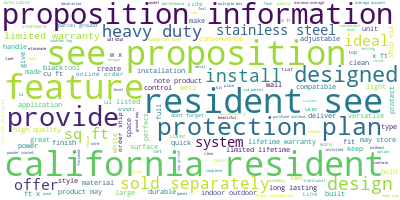

In [33]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(product_df['description_words'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [34]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [35]:
cosine_sim.shape

(20000, 20000)

In [36]:
pickle_out = open("pickle/cosine_sim.pickle","wb")
pickle.dump(cosine_sim, pickle_out,protocol=4)
pickle_out.close()

In [37]:
import pickle
pickle_in = open("pickle/cosine_sim.pickle","rb")
cosine_sim1 = pickle.load(pickle_in)


In [38]:
cosine_sim1[1]

array([0.03815803, 1.        , 0.04347497, ..., 0.        , 0.        ,
       0.        ])

In [41]:
#Construct a reverse map of indices and product titles
indices = pd.Series(product_df.index, index=product_df['product_title']).drop_duplicates()

In [42]:
indices[:10]

product_title
BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating                                       1
Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included)                                        2
Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking                      3
Lithonia Lighting Quantum 2-Light Black LED Emergency Fixture Unit                                                    4
House of Fara 3/4 in. x 3 in. x 8 ft. MDF Fluted Casing                                                               5
Valley View Industries Metal Stakes (4-Pack)                                                                          6
Toro Personal Pace Recycler 22 in. Variable Speed Self-Propelled Gas Lawn Mower with Briggs &amp; Stratton Engine     7
Hampton Bay Caramel Simple Weave Bamboo Rollup Shade - 96 in. W x 72 in. L                                            8
InSinkErator SinkTop Switc

In [43]:
# Function that takes in product title as input and outputs most similar products
def get_recommendations(query, cosine_sim=cosine_sim):
    # Get the index of the product that matches the query
    
    # gettin the index of the movie that matches the title
    idx = indices[query]
    
    # Get the pairwsie similarity scores of all products with that product
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the product based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar product
    sim_scores = sim_scores[1:15]

    # Get the product indices
    product_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar products
    return product_df['product_title'].iloc[product_indices]

In [49]:
pd.set_option('display.max_colwidth', -1)

/Users/aishwaryajakka/Anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [50]:
get_recommendations('Lithonia Lighting Quantum 2-Light Black LED Emergency Fixture Unit',cosine_sim)

17026    House of Fara 3/4 in. x 2-1/4 in. x 8 ft. MDF Fluted Casing        
7467     House of Fara 3/4 in. x 4-1/4 in. x 8 ft. MDF Fluted Casing        
12189    House of Fara 3/4 in. x 4-1/2 in. x 8 ft. MDF Crown Moulding       
13436    House of Fara 5/8 in. x 4 in. x 8 ft. MDF Base Moulding            
14136    House of Fara 8835 3/4 in. x 3-1/4 in. x 96 in. MDF Casing Moulding
5077     House of Fara 3/4 in. x 2-1/8 in. x 8 ft. MDF Panel Moulding       
5478     House of Fara 3/4 in. x 6-1/2 in. x 8 ft. MDF Base Moulding        
16038    House of Fara 1 in. x 1 in. x 8 in. MDF Inside Corner Moulding     
19315    House of Fara 3/4 in. x 1-1/4 in. x 8 ft. MDF Shoe Moulding        
11926    House of Fara 7/8 in. x 2-1/2 in. x 5 in. MDF Plinth Block         
1810     3/4 in. x 3 in. x 6 ft. MDF Fluted Window Casing Set               
15159    3/4 in. x 2-1/4 in. x 6 ft. MDF Fluted Window Casing Set           
481      3/4 in. x 2-1/4 in. x 8 ft. MDF Fluted Door Casing Set             